In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from scipy import stats, special
from scipy.optimize import minimize 
import pingouin as pg

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [15]:
db = pd.read_csv('data/db_trials.csv')
print('Participants: ', len(db['sub'].unique()))

Participants:  70


In [3]:
trace = az.from_netcdf("data/RW_vh_h.nc")

In [16]:
db['rating'] = db.rating/9
db['rectOri'] = db.rectOri/45
db['rectValue'] = db.rectValue/6

db = db.sort_values(['sub','trialNum'])

In [6]:
df = db[['sub']].sort_values('sub').drop_duplicates().reset_index(drop=True)

In [7]:
alphap_1 = az.summary(trace, var_names=['alphap_1'])[['mean']]
alphap_2 = az.summary(trace, var_names=['alphap_2'])[['mean']]
alphan_1 = az.summary(trace, var_names=['alphan_1'])[['mean']]
alphan_2 = az.summary(trace, var_names=['alphan_2'])[['mean']]

alphap_1 = alphap_1.rename(columns={'mean': "alphap_1"}).reset_index(drop=True)
alphap_2 = alphap_2.rename(columns={'mean': "alphap_2"}).reset_index(drop=True)
alphan_1 = alphan_1.rename(columns={'mean': "alphan_1"}).reset_index(drop=True)
alphan_2 = alphan_2.rename(columns={'mean': "alphan_2"}).reset_index(drop=True)

df = df.merge(alphap_1, left_index=True, right_index=True)
df = df.merge(alphap_2, left_index=True, right_index=True)
df = df.merge(alphan_1, left_index=True, right_index=True)
df = df.merge(alphan_2, left_index=True, right_index=True)

In [32]:
RW = db.merge(df, left_on='sub', right_on='sub')
RW.head()

,Unnamed: 0,trialNum,rectOri,rectValue,rating,RT,sub,gender,age,moca_score,alphap_1,alphap_2,alphan_1,alphan_2
0,0,1,1.0,0.0,0.333333,0.867000,10,M,18,28,0.124,0.385,0.261,0.115
1,1,2,0.0,0.0,0.777778,0.733563,10,M,18,28,0.124,0.385,0.261,0.115
2,2,3,1.0,1.0,0.555556,0.633451,10,M,18,28,0.124,0.385,0.261,0.115
3,3,4,0.0,0.0,0.333333,0.645628,10,M,18,28,0.124,0.385,0.261,0.115
4,4,5,1.0,0.0,0.444444,1.800124,10,M,18,28,0.124,0.385,0.261,0.115


In [33]:
sub = 0
RW['V'] = 0.5
RW['PE'] = 0
for i, row in RW.iterrows():
    if RW['sub'].iloc[i] != sub:
        sub = RW['sub'].iloc[i]
        CSa_v = 0.5
        CSb_v = 0.5
        CSa = RW['rectOri'].iloc[i]
        CSb = abs(1-CSa)
        ap = RW['alphap_1'].iloc[i]
        an = RW['alphan_1'].iloc[i]
        
    if RW['trialNum'].iloc[i] == 36:    
        ap = RW['alphap_2'].iloc[i]
        an = RW['alphan_2'].iloc[i]    
    
    outcome = RW['rectValue'].iloc[i]
    if RW['rectOri'].iloc[i] == CSa:
        RW['V'].iloc[i] = CSa_v
        RW['PE'].iloc[i] = outcome - CSa_v
        if outcome == 1:
            CSa_v = CSa_v + RW['PE'].iloc[i]*ap
        else:
            CSa_v = CSa_v + RW['PE'].iloc[i]*an
    else:
        RW['V'].iloc[i] = CSb_v
        RW['PE'].iloc[i] = outcome - CSb_v
        if outcome == 1:
            CSb_v = CSb_v + RW['PE'].iloc[i]*ap
        else:
            CSb_v = CSb_v + RW['PE'].iloc[i]*an
        
    
RW.head()    

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Unnamed: 0,trialNum,rectOri,rectValue,rating,RT,sub,gender,age,moca_score,alphap_1,alphap_2,alphan_1,alphan_2,V,PE
0,0,1,1.0,0.0,0.333333,0.867000,10,M,18,28,0.124,0.385,0.261,0.115,0.500000,-0.500000
1,1,2,0.0,0.0,0.777778,0.733563,10,M,18,28,0.124,0.385,0.261,0.115,0.500000,-0.500000
2,2,3,1.0,1.0,0.555556,0.633451,10,M,18,28,0.124,0.385,0.261,0.115,0.369500,0.630500
3,3,4,0.0,0.0,0.333333,0.645628,10,M,18,28,0.124,0.385,0.261,0.115,0.369500,-0.369500
4,4,5,1.0,0.0,0.444444,1.800124,10,M,18,28,0.124,0.385,0.261,0.115,0.447682,-0.447682


In [34]:
sp.stats.spearmanr(RW.rating, RW.V)

SpearmanrResult(correlation=0.09691097378254372, pvalue=1.0604981968783552e-11)

In [52]:
sub10 = RW[RW['sub'] == 71]

<AxesSubplot:xlabel='trialNum', ylabel='rating'>

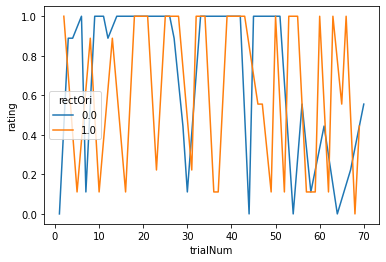

In [53]:
sns.lineplot(x='trialNum', y='rating', data=sub10, hue ='rectOri')


<AxesSubplot:xlabel='trialNum', ylabel='V'>

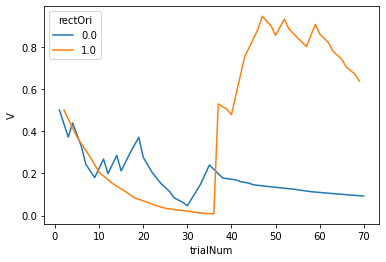

In [54]:
sns.lineplot(x='trialNum', y='V', data=sub10, hue ='rectOri')